# List of Packages 

In [1]:
from multiprocessing import Pool
from functools import partial
from contextlib import closing
from PIL import Image

import numpy as np
import pytesseract
from PIL import Image
import cv2
from matplotlib import pyplot as plt

# Importing the one of the image files (PNG in this case due to the lossless compression algorithm - we should read directly into Python from PDF though)
#from pyimagesearch.transform import four_point_transform
from skimage.filters import threshold_local
import numpy as np
import argparse
import imutils

from os import listdir
from os.path import isfile, join

# List of functions implemented

In [36]:
#auxilliary function for contour identification    
def Operate(j,cnts):
    c=cnts[j]
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    return approx


def RecursiveSplitImageByContour(image, Depth, mypath):
    ratio = image.shape[0] 
    orig = image.copy()
    #image = imutils.resize(image, height=1000)
 
    # convert the image to grayscale, blur it, and find edges
    # in the image
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(image, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    
    contours = []
    if edged is not None:

        # find the contours in the edged image, keeping only the
        # largest ones, and initialize the screen contour
        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
    
        #parallel mapping of contouring function
        func = partial(Operate, cnts=cnts)
        with closing( Pool(processes = 8, maxtasksperchild=1)) as p:
            cl_map = p.map(func, range(len(cnts)))
        
        #minimal paragrapth size required (no further splitting implied)
        MinHeight = 50 #pixels
        
        # loop over the contours
        for c in cl_map:
            # approximate the contour 
            # if our approximated contour has four points, then we
            # can assume that we have found our screen
        
        
            if len(c) == 4:
                if abs(c[0][0][1]-c[2][0][1]) > MinHeight :
                    contours.append(c)
    
        #print number of contours
        #only the first contour is used anyway but it is important that it was found
        #a.k.a number of contour is greater then 0
        numberOfContour = len(contours)
        print( str(numberOfContour) +" contours found...")
    
    else:
        print("No edges identified")
    
    #recursion ancor (recursion is stopped when no contour is found)
    if numberOfContour == 0:
        cv2.imwrite(mypath+'split_'+Depth+".png",image) 
        return
    
    #splitting image by defined contours
    splits = (image[:contours[0][0][0][1], : ],
              image[contours[0][0][0][1]:contours[0][2][0][1],: ],
              image[contours[0][2][0][1]::,  ])
        
    #counting the splits for further taxonomisation
    counter = 0
        
    #looping over splits
    for split in splits:
            
        #skipping tiny sections if height smaller then 15 pixels
        if split.shape[0] < 15:
            continue
            
        #increasing counter
        counter+=1
        #saving the file
        RecursiveSplitImageByContour(image = split, Depth = Depth+str(counter)+"_", mypath = mypath )
            

    return

#getting fields from image
def GetFields(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    fields = []
    for image in onlyfiles:
        print("--------------------------------------------------------")
        read = cv2.imread("./ImageSplits/"+image,cv2.IMREAD_GRAYSCALE)
        Image.fromarray(read)
        text = pytesseract.image_to_string("./ImageSplits/"+image)
        fields+=[text]
        print(text)
   
    return fields

#manual color filter to remove gray pixels
def FilterImage(image):
    
    for line in image:
        for i in range(0,len(line)):
            if line[i] < 100:
                line[i] = 0
            if line[i] > 135:
                line[i] = 255
                
    return image

def FindCheckBoxAndDrawIt(image):

    method = cv2.TM_SQDIFF_NORMED

    # Read the images from the file
    small_image = cv2.imread('checked.png')

    large_image = cv2.imread(image)

    result = cv2.matchTemplate(small_image, large_image, method)

    # We want the minimum squared difference
    mn,_,mnLoc,_ = cv2.minMaxLoc(result)

    # Draw the rectangle:
    # Extract the coordinates of our best match
    MPx,MPy = mnLoc

    # Step 2: Get the size of the template. This is the same size as the match.
    trows,tcols = small_image.shape[:2]

    # Step 3: Draw the rectangle on large_image
    cv2.rectangle(large_image, (MPx,MPy),(MPx+tcols,MPy+trows),(0,0,255),10)

    # Display the original image with the rectangle around the match.
    #cv2.imshow('output',large_image)

    # The image is only displayed if we call this
    #cv2.waitKey(0)

    MyInput = Image.fromarray(large_image)
    return MyInput

# Demonstrations of functionality - unfiltered images

In [37]:
# defining target folder
mypath = "./ImageSplits/"
# defining image
image = cv2.imread('../msk_RF1-0.png',cv2.IMREAD_GRAYSCALE)
# Rersive splitting of d
RecursiveSplitImageByContour(image, "0", mypath)
#reading content fields and printing them
Fields = GetFields(mypath)

4 contours found...
0 contours found...
4 contours found...
5 contours found...
0 contours found...
0 contours found...
0 contours found...
0 contours found...
5 contours found...
2 contours found...
0 contours found...
0 contours found...
0 contours found...
5 contours found...
5 contours found...
0 contours found...
5 contours found...
0 contours found...
0 contours found...
2 contours found...
0 contours found...
5 contours found...
0 contours found...
2 contours found...
0 contours found...
0 contours found...
0 contours found...
--------------------------------------------------------
fs Care
° Page 1 of 3 Co-ordination
Provide Centre

Physiotherapy Outpatient Service Referral Form

 

(Musculoskeletal)
Telephone: 0300 1310 111 Email: provide.cec@nhs.net

Note: Provide services work to NHS Connecting for Health policies and can only send responses including
patient identifiable details (PID) to email addresses that are approved by them. If you are not using an
approved email addre

# Demonstrations of functionality - filtered images

In [38]:
# defining target folder
mypath =  "./UnfilteredSplits/"
# defining image
image = cv2.imread('../msk_RF1-0.png',cv2.IMREAD_GRAYSCALE)
image = FilterImage(image)
# Rersive splitting of d
RecursiveSplitImageByContour(image, "0", mypath)
#reading content fields and printing them
Fields = GetFields(mypath)

2 contours found...
0 contours found...
1 contours found...
1 contours found...
1 contours found...
1 contours found...
0 contours found...
0 contours found...
2 contours found...
2 contours found...
0 contours found...
0 contours found...
3 contours found...
4 contours found...
0 contours found...
4 contours found...
0 contours found...
0 contours found...
0 contours found...
4 contours found...
0 contours found...
1 contours found...
0 contours found...
0 contours found...
1 contours found...
0 contours found...
0 contours found...
2 contours found...
2 contours found...
0 contours found...
0 contours found...
0 contours found...
--------------------------------------------------------
fs Care
° Page 1 of 3 Co-ordination
Provide Centre

Physiotherapy Outpatient Service Referral Form

 

(Musculoskeletal)
Telephone: 0300 1310 111 Email: provide.cec@nhs.net

Note: Provide services work to NHS Connecting for Health policies and can only send responses including
patient identifiable deta

# Demonstrate of functionality : checkbox identification

In [39]:
image = "UnfilteredSplits/split_02_3_3_2_1_.png"

In [40]:
MyInput = Image.fromarray(cv2.imread(image))

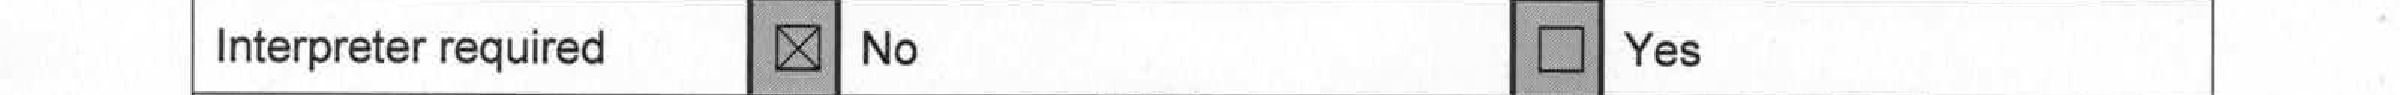

In [41]:
MyInput

In [42]:
MyInput = FindCheckBoxAndDrawIt(image)

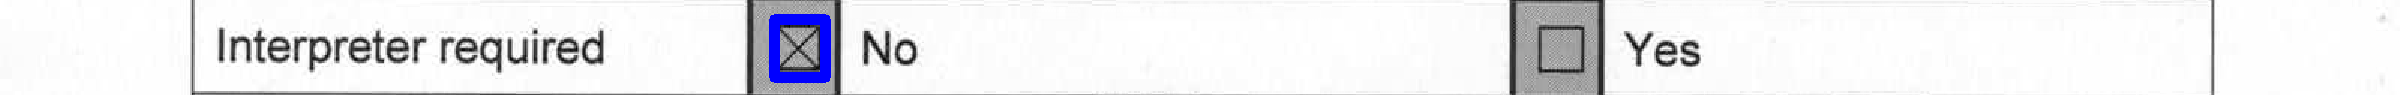

In [43]:
MyInput